In this notebook we train a RealNVP based flow model to approximate the Double Well Boltzmann Distribution.
Scroll down to the bottom for visualisation of results. 

In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
import normflow as nf
import matplotlib.pyplot as plt
import torch

from fab import FABModel, HamiltoneanMonteCarlo, Trainer, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from examples.make_flow import make_wrapped_normflowdist

## Configure Training

In [3]:
dim: int = 2
n_intermediate_distributions: int = 2
layer_nodes_per_dim = 5
batch_size: int = 128
n_iterations: int = 1500
n_eval = 100
eval_batch_size = batch_size * 10
n_plots: int = 5 # number of plots shows throughout tranining
lr: float = 1e-3
transition_operator_type: str = "hmc"  # "metropolis" or "hmc"
seed: int = 0
n_flow_layers: int = 10
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)

## Setup Double Well target distribution

In [4]:
from fab.target_distributions import ManyWellEnergy
assert dim % 2 == 0
target = ManyWellEnergy(dim, a=-0.5, b=-6)
plotting_bounds = (-3, 3)

/home/meatrobot/miniconda3/envs/FABTORCH/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


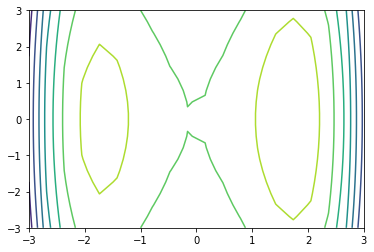

In [5]:
# plot target
plot_contours(target.log_prob, bounds=plotting_bounds)

## Setup Flow
By wrapping the [normflow library](https://github.com/VincentStimper/normalizing-flows). 

In [6]:
flow = make_wrapped_normflowdist(dim, n_flow_layers=n_flow_layers, layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = True)

## Setup transition operator

In [7]:
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltoneanMonteCarlo(
        n_ais_intermediate_distributions=n_intermediate_distributions,
        n_outer=1,
        epsilon=1.0, L=2, dim=dim,
        step_tuning_method="p_accept")
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(n_transitions=n_intermediate_distributions,
                                     n_updates=5, adjust_step_size=True)
else:
    raise NotImplementedError

## Define model, trainer and plotter

In [8]:
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
scheduler = None
logger = ListLogger() # save training history

using linear spacing as there are only 2 intermediate distribution


In [9]:
def plot(fab_model, n_samples = 300):
    fig, axs = plt.subplots(1, 2)

    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0])
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1])

    # plot flow samples
    samples_flow = fab_model.flow.sample((n_samples,))
    plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)


    # plot ais samples
    samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                               logging=False)[0]
    plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
    axs[0].set_title("flow samples")
    axs[1].set_title("ais samples")
    plt.show()

In [10]:
# Create trainer
trainer = Trainer(model=fab_model, optimizer=optimizer, logger=logger, plot=plot,
                  optim_schedular=scheduler)

# Run with visualisation

loss: 12.745503777009343:   0%|                                                                                                                                                                       | 0/1500 [00:00<?, ?it/s]

non numeric history values being saved


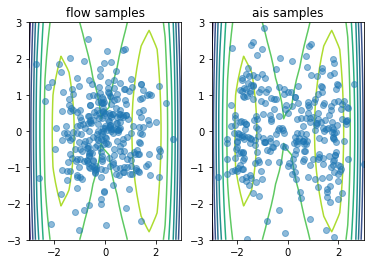

loss: 11.553781196236642:  25%|███████████████████████████████████████                                                                                                                      | 373/1500 [00:58<02:24,  7.81it/s]

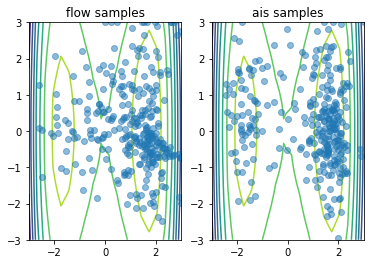

loss: 10.579796965084144:  50%|██████████████████████████████████████████████████████████████████████████████▍                                                                              | 749/1500 [01:59<01:35,  7.84it/s]

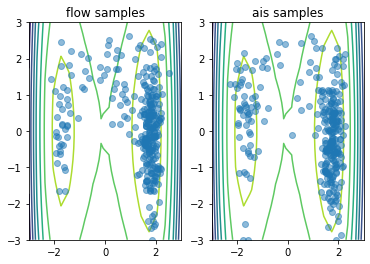

loss: 10.428845126377418:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1124/1500 [03:00<01:16,  4.91it/s]

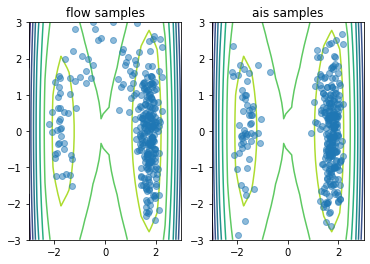

loss: 10.377480507322105: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1499/1500 [04:01<00:00,  9.67it/s]

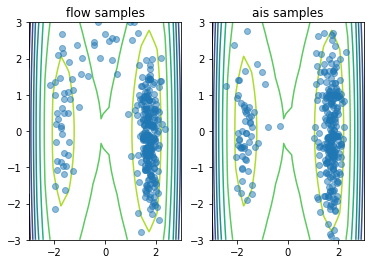

loss: 10.377480507322105: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:02<00:00,  6.18it/s]


In [11]:
# the nan's that arrise during the training are typically extreme flow samples (e.g. x=[100, 100]), 
# which give Nan values for the target density. However, these do not harm long term training.
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size)

In the below plot:
ess = effective sample size
"Distance" refers to the distance moved during each intermediate transition. 

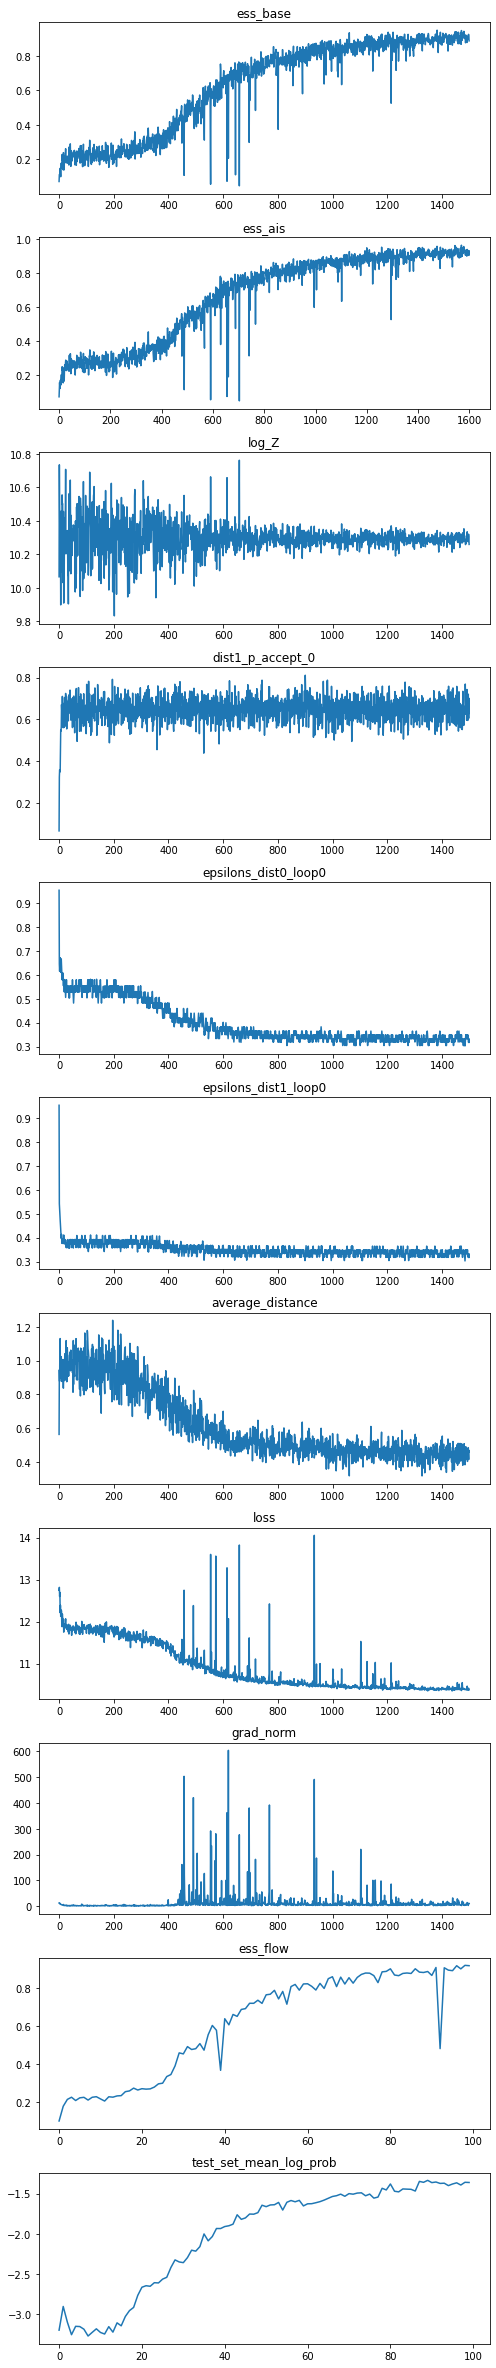

In [12]:
plot_history(logger.history)

## Visualise Trained Flow Model

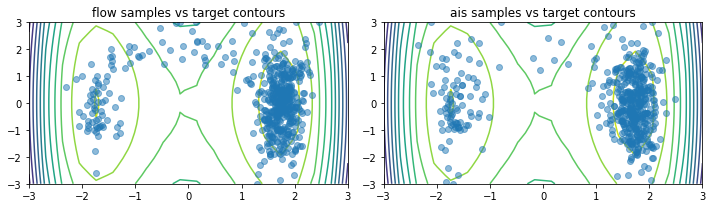

In [14]:
# plot samples on top of contours
n_samples = 500
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=10)
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=10)
# plot flow samples
samples_flow = fab_model.flow.sample((n_samples,))
plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)
axs[0].set_title("flow samples vs target contours")
# plot ais samples
samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                           logging=False)[0]
plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
axs[1].set_title("ais samples vs target contours")
plt.tight_layout()